# Wire Response Visualization

This notebook demonstrates visualization of the extracted wire response kernels and their diffusion properties.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import sys

# Add parent directory to path for imports
sys.path.append('/home/oalterka/desktop_linux/JAXTPC')

# Import our response processing modules
from tools_old.responses.diffusion_kernels import (
    create_diffusion_kernel_array,
    calculate_wire_count
)
from tools_old.responses.visualization import (
    visualize_kernel,
    visualize_diffusion_progression,
    create_parameter_sweep_gif
)

from tools_old.geometry import generate_detector

# Set matplotlib parameters for better display
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10, 8)

print("Libraries imported successfully!")

Libraries imported successfully!


## Load Diffusion Kernels

Load the pre-extracted kernel files and create diffusion kernel arrays.

In [2]:
config_path ='../../config/cubic_wireplane_config.yaml'
detector_config = generate_detector(config_path)

# Configuration
planes = ['U', 'V', 'Y']
num_s = 16  # Number of diffusion levels
wire_spacing = 0.1
time_spacing = detector_config['time_step_size_us']

# Create diffusion kernel arrays
print("Loading kernels and creating diffusionarrays...\n")
print(f"Using physics-based sigmas: trans={detector_config['max_sigma_trans_unitless']:.3f}, long={detector_config['max_sigma_long_unitless']:.3f}\n")

DKernels = create_diffusion_kernel_array(
  planes=planes,
  num_s=num_s,
  kernel_dir='.',  # Current directory
  wire_spacing=wire_spacing,
  time_spacing=time_spacing,
  max_sigma_trans_unitless=detector_config['max_sigma_trans_unitless'],
  max_sigma_long_unitless=detector_config['max_sigma_long_unitless'])

print("\n✓ Kernels loaded successfully!")
print(f"\nAvailable planes: {list(DKernels.keys())}")

Loading kernels and creating diffusionarrays...

Using physics-based sigmas: trans=0.699, long=1.617


Creating diffusion kernels for U plane...
Kernel shape: (127, 201)
DKernel shape: (16, 127, 201)
  s[1] = 0.067, σ_trans = 0.181, σ_long = 0.418
  s[2] = 0.133, σ_trans = 0.255, σ_long = 0.591
  s[3] = 0.200, σ_trans = 0.313, σ_long = 0.723
  s[4] = 0.267, σ_trans = 0.361, σ_long = 0.835
  s[5] = 0.333, σ_trans = 0.404, σ_long = 0.934
  s[6] = 0.400, σ_trans = 0.442, σ_long = 1.023
  s[7] = 0.467, σ_trans = 0.478, σ_long = 1.105
  s[8] = 0.533, σ_trans = 0.511, σ_long = 1.181
  s[9] = 0.600, σ_trans = 0.542, σ_long = 1.253
  s[10] = 0.667, σ_trans = 0.571, σ_long = 1.321
  s[11] = 0.733, σ_trans = 0.599, σ_long = 1.385
  s[12] = 0.800, σ_trans = 0.625, σ_long = 1.447
  s[13] = 0.867, σ_trans = 0.651, σ_long = 1.506
  s[14] = 0.933, σ_trans = 0.676, σ_long = 1.562
  s[15] = 1.000, σ_trans = 0.699, σ_long = 1.617

Creating diffusion kernels for V plane...
Kernel shape: (127, 201)
DKerne

## Visualize Original Kernels

Display the original (non-diffused) kernels for each wire plane.

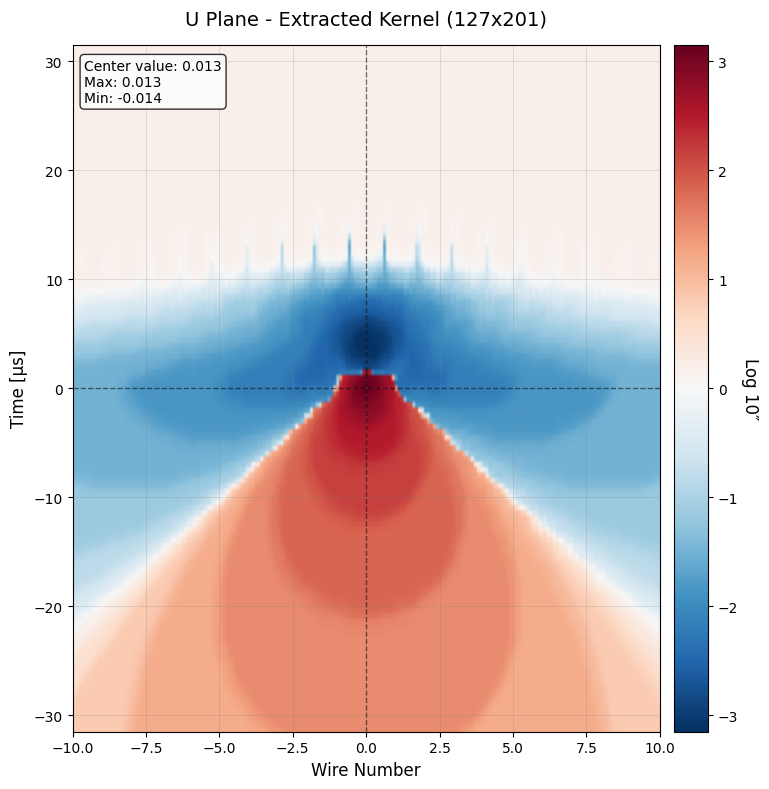

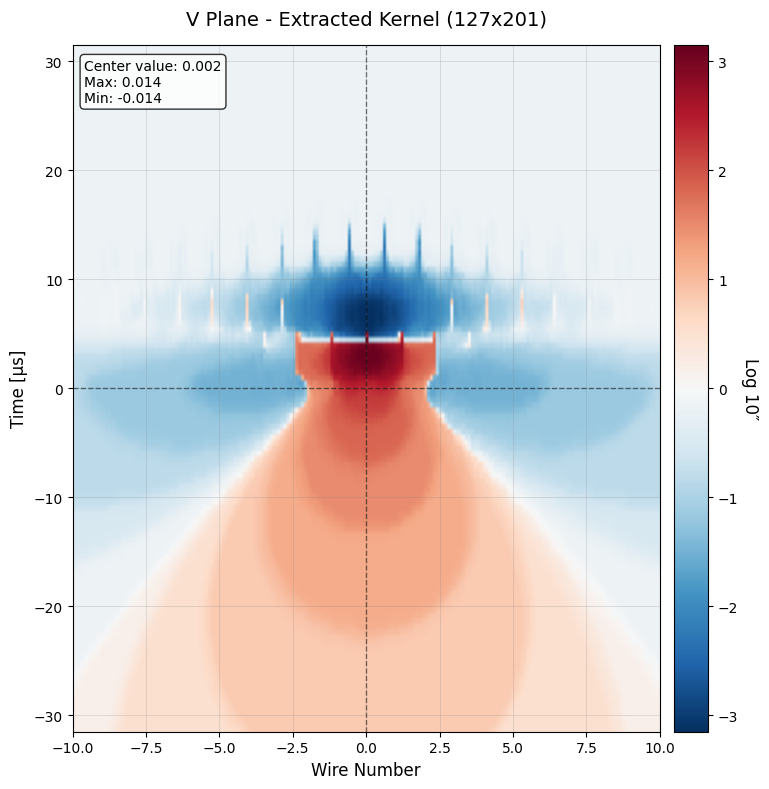

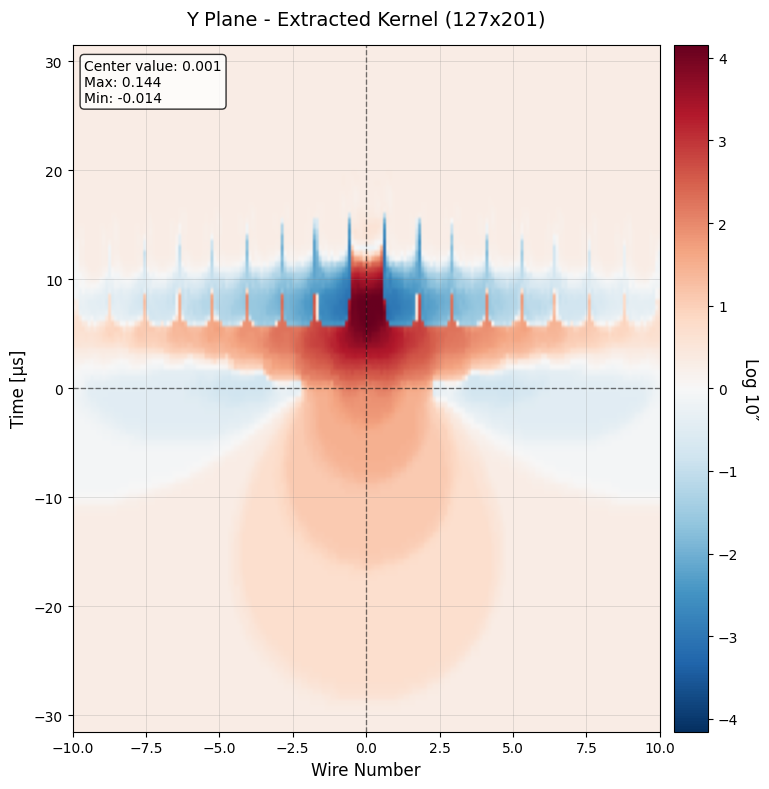

In [3]:
# Visualize original kernels (s=0) for each plane
for plane in DKernels.keys():
    DKernel, linear_s, kernel_shape, x_coords, y_coords = DKernels[plane]
    
    # Extract original kernel (s=0)
    original_kernel = DKernel[0]
    
    # Create visualization
    fig, ax = visualize_kernel(
        original_kernel, 
        x_coords, 
        y_coords, 
        plane=plane,
        figsize=(8, 8)
    )
    
    # Add some statistics
    center_idx = (kernel_shape[0]//2, kernel_shape[1]//2)
    center_value = original_kernel[center_idx]
    max_value = np.max(original_kernel)
    min_value = np.min(original_kernel)
    
    ax.text(0.02, 0.98, f'Center value: {center_value:.3f}\nMax: {max_value:.3f}\nMin: {min_value:.3f}',
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

## Visualize Diffusion Progression

Show how the kernels change with increasing diffusion parameter s.

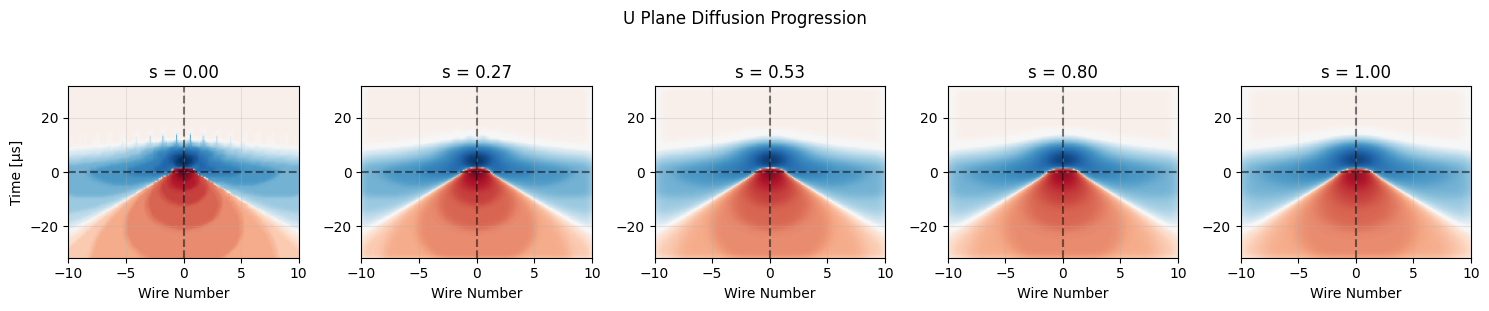

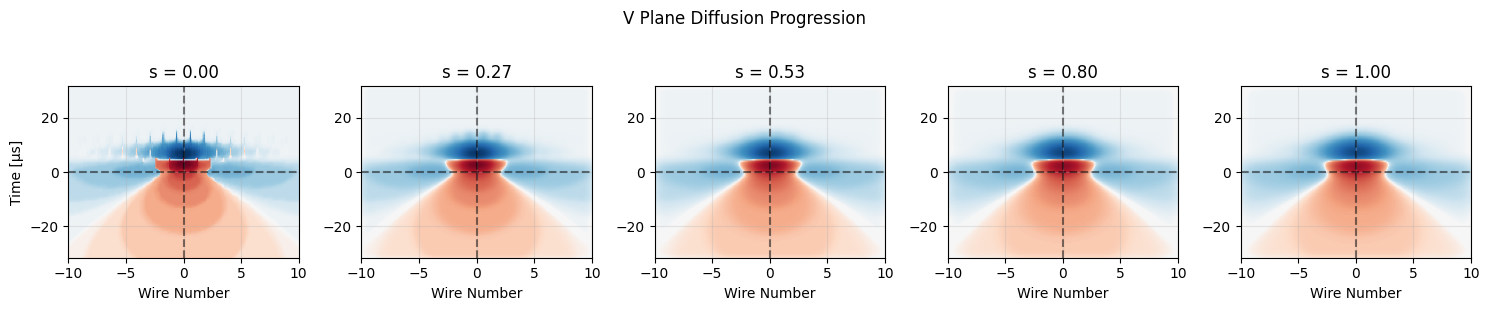

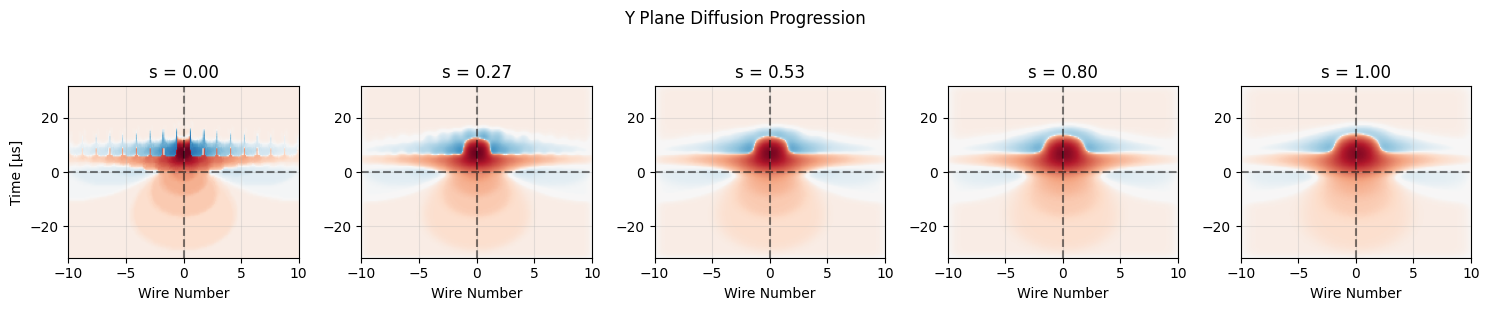

In [4]:
# Show diffusion progression for each plane
for plane in DKernels.keys():
    DKernel, linear_s, kernel_shape, x_coords, y_coords = DKernels[plane]
    
    fig = visualize_diffusion_progression(
        DKernel, 
        linear_s, 
        x_coords, 
        y_coords, 
        plane=plane,
        figsize=(15, 3)
    )
    
    plt.tight_layout()
    plt.show()

## Compare Planes

Compare the three wire planes side by side.

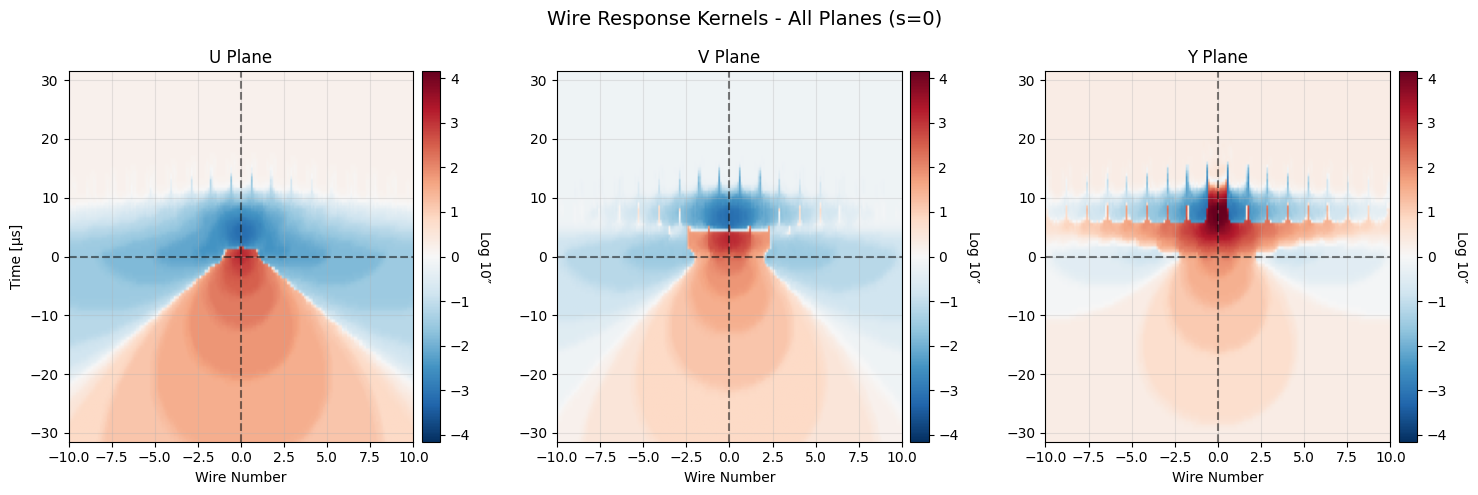

Colorbar range: [-4.2, 4.2] (symmetric around 0)


In [5]:
# Compare all three planes at s=0
from tools_old.responses.visualization import actual_to_paper_log10

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Convert all kernels first to find global limits
all_kernels_log10 = []
for plane in ['U', 'V', 'Y']:
    if plane in DKernels:
        DKernel, _, _, _, _ = DKernels[plane]
        kernel = DKernel[0]
        kernel_log10 = actual_to_paper_log10(np.array(kernel))
        all_kernels_log10.append(kernel_log10)

# Find maximum absolute value for symmetric colorbar
vmax = max(np.max(np.abs(k)) for k in all_kernels_log10)
vmin = -vmax

for i, (plane, kernel_log10) in enumerate(zip(['U', 'V', 'Y'], all_kernels_log10)):
    if plane in DKernels:
        DKernel, linear_s, kernel_shape, x_coords, y_coords = DKernels[plane]
        
        # Create image with symmetric colorbar
        im = axes[i].imshow(kernel_log10, aspect='auto',
                           extent=[x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]],
                           cmap='RdBu_r', origin='lower', vmin=vmin, vmax=vmax)
        
        # Formatting
        axes[i].set_xlabel('Wire Number')
        axes[i].set_ylabel('Time [μs]' if i == 0 else '')
        axes[i].set_title(f'{plane} Plane')
        axes[i].grid(True, alpha=0.3)
        axes[i].axvline(x=0, color='black', linestyle='--', alpha=0.5)
        axes[i].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        
        # Individual colorbar (all will have same scale)
        cbar = plt.colorbar(im, ax=axes[i], pad=0.02)
        cbar.set_label('Log 10″', rotation=270, labelpad=15)

plt.suptitle('Wire Response Kernels - All Planes (s=0)', fontsize=14)
plt.tight_layout()
plt.show()

print(f"Colorbar range: [{vmin:.1f}, {vmax:.1f}] (symmetric around 0)")

## Visualize Interpolation Steps

Show the detailed interpolation process with the 2x2 layout visualization.


Interpolation parameters:
  s_observed=0.010 -> s_idx=0, s_alpha=0.150
  w_offset=0.250 -> w_base_bin=2, w_alpha=0.500
  t_offset=0.150
  num_wires=20, Expected output shape: (20, 126)


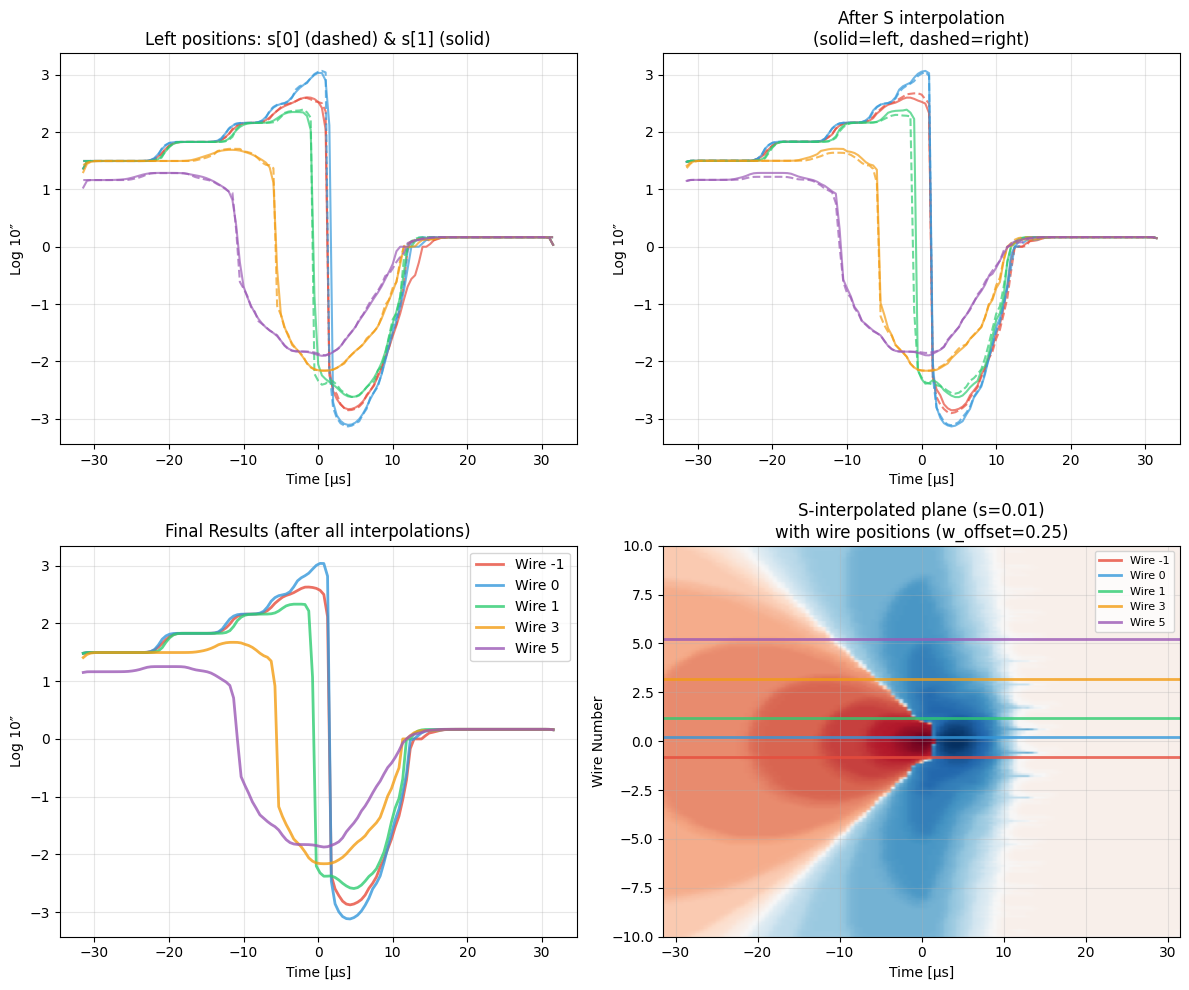

In [6]:
# Import the visualization function
from tools_old.responses.visualization import visualize_interpolation_steps

# Show interpolation steps
fig = visualize_interpolation_steps(DKernels, plane='U',
                                  s_observed=0.01, w_offset=0.25, t_offset=0.15,
                                  verbose=True)
plt.show()

# Create GIF animations for different parameter sweeps using the detailed visualization
# Note: This will create GIF files in the current directory

In [7]:
# 1. Diffusion parameter (s) sweep
print("Creating diffusion parameter sweep animation...")
create_parameter_sweep_gif(
    visualize_interpolation_steps,
    DKernels,
    plane='Y',
    parameter='s_observed',
    param_range=(0, 1),
    fixed_params={'w_offset': 0.25, 't_offset': 0.15},
    output_filename='gifs/diffusion_sweep_detailed_Y.gif',
    n_frames=30,
    fps=10
)
print("✓ Created diffusion_sweep_detailed_Y.gif")

Creating diffusion parameter sweep animation...
Creating parameter sweep GIF for s_observed...
  Range: 0.000 to 1.000
  Generating frame 1/30 (s_observed=0.000)
  Generating frame 2/30 (s_observed=0.067)
  Generating frame 3/30 (s_observed=0.133)
  Generating frame 4/30 (s_observed=0.200)
  Generating frame 5/30 (s_observed=0.267)
  Generating frame 6/30 (s_observed=0.333)
  Generating frame 7/30 (s_observed=0.400)
  Generating frame 8/30 (s_observed=0.467)
  Generating frame 9/30 (s_observed=0.533)
  Generating frame 10/30 (s_observed=0.600)
  Generating frame 11/30 (s_observed=0.667)
  Generating frame 12/30 (s_observed=0.733)
  Generating frame 13/30 (s_observed=0.800)
  Generating frame 14/30 (s_observed=0.867)
  Generating frame 15/30 (s_observed=0.933)
  Generating frame 16/30 (s_observed=1.000)
  Generating frame 17/30 (s_observed=0.929)
  Generating frame 18/30 (s_observed=0.857)
  Generating frame 19/30 (s_observed=0.786)
  Generating frame 20/30 (s_observed=0.714)
  Generati

In [8]:
# 2. Wire offset sweep
print("Creating wire offset sweep animation...")
create_parameter_sweep_gif(
    visualize_interpolation_steps,
    DKernels,
    plane='Y',
    parameter='w_offset',
    param_range=(0, 0.99),
    fixed_params={'s_observed': 0.3, 't_offset': 0.15},
    output_filename='gifs/wire_offset_sweep_detailed_Y.gif',
    n_frames=60,
    fps=20
)
print("✓ Created wire_offset_sweep_detailed_Y.gif")

Creating wire offset sweep animation...
Creating parameter sweep GIF for w_offset...
  Range: 0.000 to 0.990
  Generating frame 1/60 (w_offset=0.000)
  Generating frame 2/60 (w_offset=0.033)
  Generating frame 3/60 (w_offset=0.066)
  Generating frame 4/60 (w_offset=0.099)
  Generating frame 5/60 (w_offset=0.132)
  Generating frame 6/60 (w_offset=0.165)
  Generating frame 7/60 (w_offset=0.198)
  Generating frame 8/60 (w_offset=0.231)
  Generating frame 9/60 (w_offset=0.264)
  Generating frame 10/60 (w_offset=0.297)
  Generating frame 11/60 (w_offset=0.330)
  Generating frame 12/60 (w_offset=0.363)
  Generating frame 13/60 (w_offset=0.396)
  Generating frame 14/60 (w_offset=0.429)
  Generating frame 15/60 (w_offset=0.462)
  Generating frame 16/60 (w_offset=0.495)
  Generating frame 17/60 (w_offset=0.528)
  Generating frame 18/60 (w_offset=0.561)
  Generating frame 19/60 (w_offset=0.594)
  Generating frame 20/60 (w_offset=0.627)
  Generating frame 21/60 (w_offset=0.660)
  Generating frame

In [9]:
# 3. Time offset sweep
print("Creating time offset sweep animation...")
create_parameter_sweep_gif(
    visualize_interpolation_steps,
    DKernels,
    plane='Y',
    parameter='t_offset',
    param_range=(0, 0.49),
    fixed_params={'s_observed': 0.3, 'w_offset': 0.25},
    output_filename='gifs/time_offset_sweep_detailed_Y.gif',
    n_frames=20,
    fps=10
)
print("✓ Created time_offset_sweep_detailed_Y.gif")

Creating time offset sweep animation...
Creating parameter sweep GIF for t_offset...
  Range: 0.000 to 0.490
  Generating frame 1/20 (t_offset=0.000)
  Generating frame 2/20 (t_offset=0.049)
  Generating frame 3/20 (t_offset=0.098)
  Generating frame 4/20 (t_offset=0.147)
  Generating frame 5/20 (t_offset=0.196)
  Generating frame 6/20 (t_offset=0.245)
  Generating frame 7/20 (t_offset=0.294)
  Generating frame 8/20 (t_offset=0.343)
  Generating frame 9/20 (t_offset=0.392)
  Generating frame 10/20 (t_offset=0.441)
  Generating frame 11/20 (t_offset=0.490)
  Generating frame 12/20 (t_offset=0.436)
  Generating frame 13/20 (t_offset=0.381)
  Generating frame 14/20 (t_offset=0.327)
  Generating frame 15/20 (t_offset=0.272)
  Generating frame 16/20 (t_offset=0.218)
  Generating frame 17/20 (t_offset=0.163)
  Generating frame 18/20 (t_offset=0.109)
  Generating frame 19/20 (t_offset=0.054)
  Generating frame 20/20 (t_offset=0.000)

Creating GIF...
GIF saved as: gifs/time_offset_sweep_detail